In [1]:
base_dir = "/home/parth/Machine Learning/Datasets/North Corp/Ajanta"

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from datetime import datetime
import os
#from sklearn.cluster import DBSCAN
#from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [2]:
file = os.path.join(base_dir , os.listdir(base_dir)[0])
data = pd.read_csv(file)

In [3]:
data["dataSeconds"] = data["updateddate"].apply(lambda x : datetime.strptime(x , "%Y-%m-%d %H:%M:%S")).apply(
    lambda x : (x - datetime(1970 , 1 , 1)).total_seconds()
)
data["day"] = data["updateddate"].apply(lambda x : datetime.strptime(x , "%Y-%m-%d %H:%M:%S"))
data["day"] = data["updateddate"].apply(lambda x: x.split(' ')[0])

In [4]:
useful_cols = ["longitude" , "latitude" , "dataSeconds"]

X = data[useful_cols].values

In [5]:
def createChangingCols(data):
    data["islatChanging"] = data.latitude.apply(lambda x : round(x , 4)).diff()
    data["islonChanging"] = data.longitude.apply(lambda x : round(x , 4)).diff()
    data["eitherChanging"] = abs(data["islatChanging"]) + abs(data["islonChanging"])
    def temp(x):
        if x > 0:
            return 1
        else :
            return 0
    data.eitherChanging = data.eitherChanging.apply(temp)
    return data

In [6]:
def plotData(data , y , trip_mask = None , per_day = False):
    %matplotlib notebook
    fig = plt.figure(figsize=(8 ,8) )
    ax = plt.axes(projection='3d')
    if per_day:
        temp = data[data.day == data.day.unique()[0]]
    else:
        temp = data
    mask = (temp.eitherChanging == 1) | (temp.speed != 0)
    temp = temp[ mask ]
    if trip_mask is not None :
        temp = temp[trip_mask]
        y = y[trip_mask]
    
    ax.scatter3D(temp["longitude"] , temp["latitude"] , temp["dataSeconds"] - temp["dataSeconds"].min() 
            , c=y , cmap=plt.cm.jet)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_zlabel("Time")
    plt.show()

In [7]:
def createPosition(data , i):
    data["Position"] = None
    for index , (a , b) in enumerate(zip(data["latitude"] , data["longitude"])):
        data.at[index , "Position"] = round(a , i) , round(b , i)
    return data

In [8]:
data = createChangingCols(data)
mask = np.logical_or( (data.eitherChanging == 1)  , data.speed != 0 )
data_changed = data[mask]
y = KMeans(n_clusters=len(data_changed.day.unique())).fit(data_changed[useful_cols].values)
y = y.predict(data_changed[useful_cols].values)
data = createPosition(data , 3)

In [9]:
data["Cluster"] = None
i = 0
for index  , m in enumerate(mask):
    if m :
        data.at[index , "Cluster"] = y[i]
        i = i + 1
ClusterIDS = data[np.logical_not(data.Cluster.isnull())]["Cluster"].unique()

In [10]:
def getClusterVector(data , clusterid):
    temp = data[data.Cluster == clusterid]
    start = temp["Position"].iloc[0]
    end = temp["Position"].iloc[-1]
    return (end[0] - start[0] , end[1]-start[1])

In [11]:
def distance(p1 , p2):
    dist = (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2
    return np.sqrt(dist)
    
def sameTripClusterHUB(data , cl1 , cl2 , init_pos):
    t1 = data[data.Cluster == cl1]
    t2 = data[data.Cluster == cl2]
    final_pos = t2.Position.iloc[-1]
    init_pos2 = t2.Position.iloc[0]
    d2 = distance(init_pos2 , final_pos)
    #print(d2)
    td1  = t1.total_distance.max() - t1.total_distance.min()
    td2  = t2.total_distance.max() - t2.total_distance.min()
    
    cond1 = distance(t1.Position.iloc[-1] , t2.Position.iloc[0])
    cond1 = cond1 < 0.05
    if cond1 :
        c1 = getClusterVector(data , cl1)
        c2 = getClusterVector(data , cl2)
        dot_product = c1[0] * c2[0] + c1[1] * c2[1]
        mag = np.sqrt(c1[0]**2 + c1[1]**2) * np.sqrt(c2[0] ** 2 + c2[1] ** 2)
        cos = dot_product / mag
        angle = np.arccos(cos)
        if angle < (2.0 * np.pi / 3.0 ):
            score = 1
        else:
            score = -1
        if distance(final_pos , init_pos) < 0.3:
            raise Exception("TripOver")
    else:
        score = -1
    return (score > 0 ) and (td1 > 20) and (td2 > 20) and (d2 > 0.1)

In [12]:
def plotCluster(data , clusterid , ax , c='yellow'):
    temp = data[data.Cluster == clusterid]
    ax.scatter3D(xs = temp["longitude"] ,ys = temp["latitude"] , zs=temp["dataSeconds"] , c=c)

In [13]:
def plotTrip(trip , showHubs = None):
    %matplotlib notebook
    fig = plt.figure(figsize=(8 , 8))
    ax = plt.axes(projection='3d')
    for index , ClusterID in enumerate(trip):
        plotCluster(data ,ClusterID , ax , colourmap[index] )
    if showHubs is not None:
        x = findHubs(showHubs)
        lats  = x[: , 0]
        longs = x[: , 1]
        time = data[data.Cluster == trip[0]]["dataSeconds"].mean()
        ax.scatter3D(ys=lats , xs=longs , zs= time , s=100)
    plt.show()

In [14]:
def makeTrips(startClusterID ):
    index = 0
    if startClusterID == 'start':
        startClusterID = ClusterIDS[0]
    final_dict = {}
    normal = 0
    exps = 0
    while True :
        final = []
        previd = startClusterID
        final.append(previd)
        i = np.argwhere((ClusterIDS== startClusterID).astype(np.float32))[0][0]
        i = i + 1
        try :
            nextid = ClusterIDS[i]
        except IndexError:
            break
        init_pos = data[data.Cluster == startClusterID]["Position"].iloc[0]
        try :
            while sameTripClusterHUB(data , previd , nextid , init_pos):
                final.append(nextid)
                i = i + 1
                previd = nextid
                try :
                    nextid = ClusterIDS[i]
                except IndexError:
                    final_dict[index] = final
                    index = index + 1
                    break
            else :
                final_dict[index] = final
                index = index + 1
                startClusterID = nextid
                normal = normal + 1
                continue
        except Exception:
            exps = exps + 1
            final.append(nextid)
            i = i + 1
            final_dict[index] = final
            index = index + 1
            try :
                startClusterID = ClusterIDS[i]
            except IndexError:
                break
            continue
        break
    print(normal)
    print(exps)
    return final_dict

In [15]:
colourmap = {
    0 : 'red',
    1 : 'green',
    2 : 'yellow',
    3 : 'blue',
    4 : 'pink',
    5 : 'crimson',
    6 : 'purple',
    7 : 'brown',
    8 : 'grey',
    9 : 'indigo',
    10 : 'lightgreen',
    11: 'red'
}

In [16]:
def makeTripsindf(data , trips):
    data["TripID"] = None
    for index in range(len(trips)):
        try :
            for clus in trips[index]:
                data.at[data.Cluster == clus , "TripID"] = index
        except Exception :
            pass
    return data

In [17]:
def findHubs(hubs):
    temp = data[["latitude" , "longitude"]].values
    temp[np.isinf(temp)] = 0
    temp[np.isnan(temp)] = 0
    means = KMeans(n_clusters=hubs).fit(temp)
    return means.cluster_centers_

In [18]:
def sort_trips(trips):
    sorting_list = []
    for trip in trips.values():
        first_clus = trip[0]
        sorting_list.append(data[data.Cluster == first_clus].dataSeconds.iloc[0])
    sorting_list = np.array(sorting_list)
    indx = np.argsort(sorting_list)
    new_trips = {}
    for i , ind in enumerate(indx):
        new_trips[i] = trips[ind]
    return new_trips

In [19]:
def findTripLength(trip):
    length = 0
    for clus in trip:
        temp = data[data.Cluster == clus]
        length += temp.total_distance.iloc[-1] - temp.total_distance.iloc[0]
    return length

def findAvgTripLength(trips , avg = True):
    counter = 0
    length = []
    for trip in trips.values():
        length.append(findTripLength(trip))
        counter += 1
    if avg:
        length = sum(length) / counter
    return length

In [20]:
def makeCompleteTrips(data ,trips):
    locations = []
    for trip in trips.values():
        temp = data[data.Cluster == trip[-1]].Position
        end = temp.iloc[-1]
        start = temp.iloc[0]
        locations.append((start , end))
    init_pos = locations[0][0]
    #for i , loc in enumerate(locations):
    #    print( i , distance( init_pos , loc[1]))

In [21]:
 def plotTrips(trips  , showHubs= None , limit = 1):
    %matplotlib notebook
    fig = plt.figure(figsize=(8 , 8))
    ax = plt.axes(projection='3d')
    for trip in trips.values():
        for index , ClusterID in enumerate(trip):
            plotCluster(data ,ClusterID , ax , colourmap[index] )
    if showHubs is not None:
        #x = findHubs(showHubs)
        x = list(dict(data.Position.value_counts()).keys())[:showHubs]
        print(x)
        lats  = [a for a , b in x][:limit] #x[: , 0][:limit]
        longs = [b for a , b in x][:limit] #x[: , 1][:limit]
        time = data[data.Cluster == trip[0]]["dataSeconds"].mean()
        ax.scatter3D(ys=lats , xs=longs , zs= time , s=100)
    plt.show()
    
def concatTrips(lis):
    return {k:trips[k] for k in lis if k in trips} 

In [22]:
def findRoute(trip):
    route = []
    for clus in trip:
        temp = data[data.Cluster == clus]
        route  = route + temp.Position.to_list()
    return route

In [23]:
def matchRoutes(route1 , route2):
    y = 0
    for p1 in route1:
        x = []
        for p2 in route2:
            x.append(distance(p1 , p2))
        y += min(x)
    return y

In [61]:
x = np.array(findAvgTripLength(trips , avg=False))
x[np.logical_and(x > 30  , x < 3000)]

array([1073.72,   89.61,  358.39,  387.17,  482.92,  181.71,   73.15,
        846.51, 1027.67,   80.98,  144.24,  157.3 ,  730.22,  827.44,
       1043.06,  882.46,  172.52,  458.55,  329.25,  798.  ,  247.09,
        128.1 ,  605.58,  108.44,  661.8 ,  453.09,  354.09,   88.61,
        390.45,  291.58,  131.54,  405.13,  109.29,  775.28,  528.85,
        453.67,  222.19,  457.34,  415.64,  350.53,  302.91,  383.53,
        396.24,  405.86,  887.46,  837.14,  740.82,  559.13,  118.49,
        349.26,   41.27,  690.66,  537.21,  775.61,  451.92,  406.21,
        834.75,  367.8 ,  386.18,  367.83,  313.27,  468.18,  455.12,
        108.2 ,  528.62,  598.25,  549.37,  576.47,  335.88,  108.22,
        640.27,  516.2 ])

[37 , 155 , 5 , 70]
%matplotlib notebook
fig = plt.figure(figsize=(8 , 8))
ax = plt.axes(projection='3d')
plotCluster(data , 31    , ax , c=colourmap[0])
plotCluster(data , 149    , ax , c=colourmap[1])
plotCluster(data , 113      , ax , c=colourmap[2])
plotCluster(data , 3     , ax , c=colourmap[3])
plt.show()

In [25]:
data

,Unnamed: 0,positionid,vehicleid,gtpdriverid,version,heading,latitude,longitude,altitude,address,...,msg_trigger_type,current_fuel_level,received_date,dataSeconds,day,islatChanging,islonChanging,eitherChanging,Position,Cluster
0,0,719040068,10876,NaN,0,0,19.250433,73.043070,8.0,NaN,...,IGNITION_ON,51.200001,NaN,1.543623e+09,2018-12-01,NaN,NaN,0,"(19.25, 73.043)",None
1,1,719040369,10876,NaN,0,0,19.250433,73.043070,8.0,NaN,...,PERIODIC,51.599998,NaN,1.543623e+09,2018-12-01,0.0000,0.0000,0,"(19.25, 73.043)",None
2,2,719040723,10876,NaN,0,67,19.250433,73.043070,8.0,NaN,...,MOVEMENT,51.599998,NaN,1.543623e+09,2018-12-01,0.0000,0.0000,0,"(19.25, 73.043)",20
3,3,719049781,10876,NaN,0,178,19.249469,73.043996,-1.0,NaN,...,NO_MOVEMENT,50.799999,NaN,1.543623e+09,2018-12-01,-0.0009,0.0009,1,"(19.249, 73.044)",20
4,4,719052053,10876,NaN,0,0,19.249479,73.043942,-1.0,NaN,...,PERIODIC,51.200001,NaN,1.543623e+09,2018-12-01,0.0000,-0.0001,1,"(19.249, 73.044)",20
5,5,719056108,10876,NaN,0,0,19.249440,73.043995,5.0,NaN,...,PERIODIC,51.200001,NaN,1.543624e+09,2018-12-01,-0.0001,0.0001,1,"(19.249, 73.044)",20
6,6,719060095,10876,NaN,0,0,19.249447,73.044012,10.0,NaN,...,PERIODIC,51.200001,NaN,1.543624e+09,2018-12-01,0.0000,0.0000,0,"(19.249, 73.044)",None
7,7,719064099,10876,NaN,0,0,19.249433,73.044019,11.0,NaN,...,PERIODIC,51.200001,NaN,1.543624e+09,2018-12-01,0.0000,0.0000,0,"(19.249, 73.044)",None
8,8,719068529,10876,NaN,0,0,19.249432,73.044035,11.0,NaN,...,PERIODIC,51.200001,NaN,1.543625e+09,2018-12-01,0.0000,0.0000,0,"(19.249, 73.044)",None
9,9,719072868,10876,NaN,0,0,19.249460,73.043993,11.0,NaN,...,PERIODIC,51.200001,NaN,1.543625e+09,2018-12-01,0.0001,0.0000,1,"(19.249, 73.044)",20


In [26]:
trips = makeTrips('start')
print(trips == sort_trips(trips))
lengths = findAvgTripLength(trips , avg = False)
lengths = np.array(lengths) 
x = lengths[np.logical_and(lengths < 2000 , lengths > 20)]
complete_trips = makeCompleteTrips(data , trips)
matchRoutes(findRoute(trips[0]) , findRoute(trips[1]))
trips_data = makeTripsindf(data , trips)
#trips_data.to_csv("File.csv")

/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


77
5
True


In [24]:
def findSameRoutes(trips , i1):
    same_route_list = []
    distances = []
    for i2 in trips.keys():
        if i1 != i2 :
            d12 = matchRoutes(findRoute(trips[i1]) , findRoute(trips[i2]))
            distances.append(d12)
            if d12 < 10:
                same_route_list.append(i2)
    return same_route_list , distances

In [44]:
srl , x = 

<IPython.core.display.Javascript object>


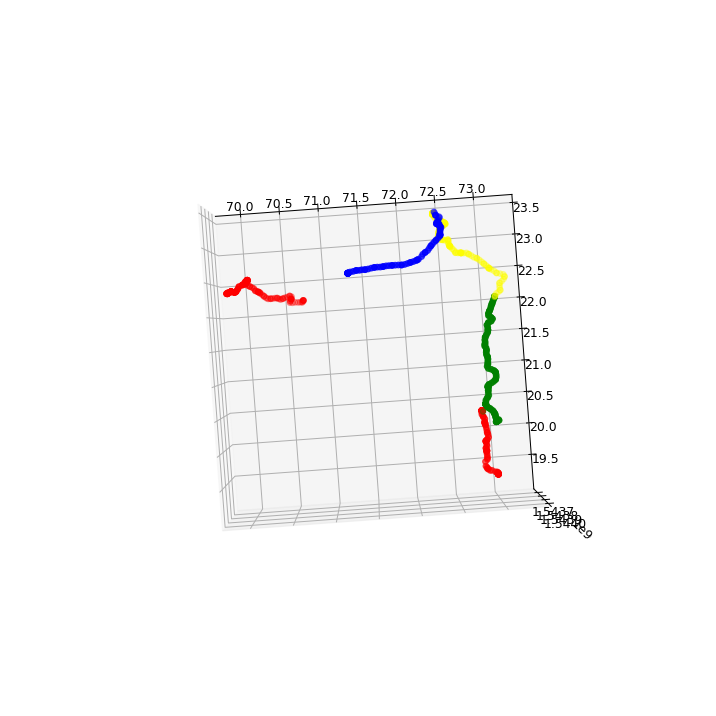

In [29]:
plotTrips(concatTrips([0 , 1]) )

In [38]:
max(x)

592.2248314855609

In [52]:
len(trips)

86

[3,
 7,
 8,
 9,
 10,
 14,
 15,
 16,
 20,
 21,
 23,
 25,
 30,
 34,
 35,
 37,
 40,
 41,
 43,
 44,
 45,
 46,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 58,
 59,
 60,
 62,
 64,
 65,
 67,
 68,
 69,
 70,
 72,
 74,
 77,
 83]

In [55]:
findSameRoutes(trips , 2)[0]

[0,
 3,
 24,
 29,
 36,
 40,
 43,
 44,
 45,
 48,
 49,
 51,
 55,
 64,
 67,
 68,
 69,
 70,
 71,
 77,
 82]

In [56]:
findRoute(trip=trips[0])

[(19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.25, 73.04),
 (19.26, 73.04),
 (19.27, 73.04),
 (19.27, 73.04),
 (19.27, 73.04),
 (19.27, 73.04),
 (19.29, 73.03),
 (19.29, 73.03),
 (19.3, 73.01),
 (19.32, 72.96),
 (19.32, 72.94),
 (19.34, 72.92),
 (19.36, 72.91),
 (19.36, 72.91),
 (19.38, 72.9),
 (19.4, 72.89),
 (19.47, 72.89),
 (19.5, 72.91),
 (19.52, 72.92),
 (19.54, 72.92),
 (19.58, 72.92),
 (19.62, 72.91),
 (19.62, 72.91),
 (19.63, 72.92),
 (19.63, 72.92),
 (19.63, 72.92),
 (19.64, 72.92),
 (19.68, 72.91),
 (19.68, 72.91),
 (19.71, 72.92),
 (19.73, 72.92),
 (19.77, 72.91),
 (19.78, 72.91),
 (19.79, 72.91),
 (19.79, 72.91),
 

<IPython.core.display.Javascript object>


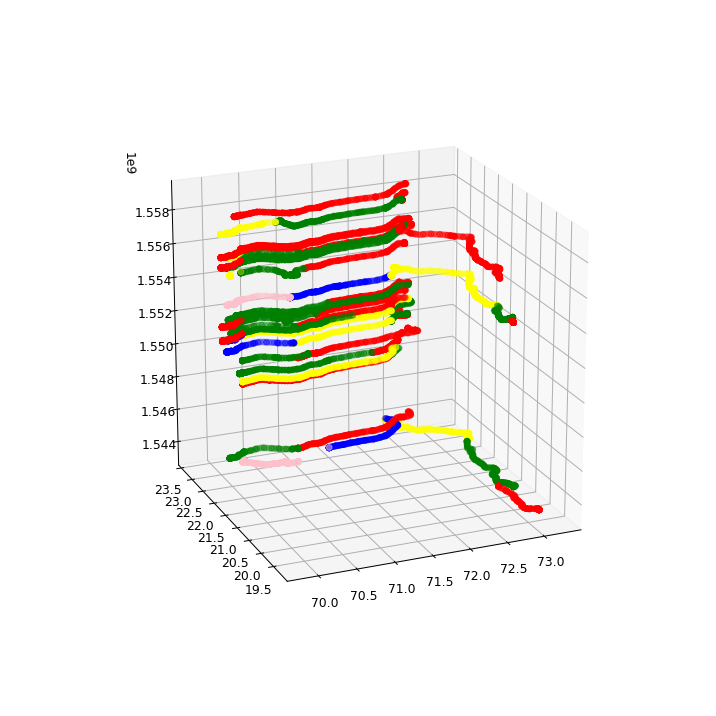

In [54]:
plotTrips(concatTrips(findSameRoutes(trips , 2)[0]) , showHubs=None )

In [62]:
complete = """
Mumbai
Pune
Nagpur
Nashik
Vasai-Virar
Aurangabad
Solapur
Bhiwandi
Amravati
Malegaon
Kolhapur
Nanded
Sangli [Sangali]
Jalgaon
Akola
Latur
Ahmadnagar
Dhule
Ichalkaranji
Chandrapur
Parbhani
Jalna
Bhusawal
Navi Mumbai
Panvel
"""

In [65]:
city_list = complete.strip("\n").split('\n')

In [77]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="NorthCorpNew")

In [79]:
positions = []
city_list_updated = []
for city in city_list:
    x = geolocator.geocode(city)
    if x is not None:
        city_list_updated.append(city)
        pos = (x.latitude , x.longitude)
        positions.append(pos)

In [81]:
positions

[(18.9387711, 72.8353355),
 (18.5203062, 73.8543185),
 (21.1500964, 79.0127048991187),
 (20.216667, 74.083333),
 (19.4258788, 72.8224901),
 (24.75, 84.5),
 (17.6715272, 75.8975502),
 (19.3025562, 73.0588072),
 (21.0857492, 77.666978),
 (20.5575459, 74.5242544),
 (16.6603273, 74.1960037872403),
 (18.916667, 77.5),
 (21.0137606, 75.5627048),
 (20.77031765, 77.190806035826),
 (18.3983393, 76.562087),
 (19.25, 74.75),
 (20.898, 74.7732),
 (16.6959348, 74.4555755),
 (20.0, 80.0),
 (19.262469, 76.7718),
 (19.96549, 75.8270463555813),
 (21.04572, 75.7808079),
 (19.0308262, 73.0198537),
 (18.9895249, 73.1221935)]

In [83]:
len(city_list_updated)

24

In [73]:
concatTrips([8 , 9])

{8: [57, 83], 9: [25]}